In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
welding_data = pd.read_excel("./data/Welding Data Set_01.xlsx", index_col ="idx")

In [3]:
welding_data.head()

,Machine_Name,Item No,working time,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
idx,,,,,,,,,
1,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.33,14.57,2.701,72.0
2,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.57,2.701,72.0
3,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,71.0
4,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,72.0
5,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.56,2.704,72.0


## 데이터 특성 파악

In [4]:
welding_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11939 entries, 1 to 669
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Machine_Name      11939 non-null  object        
 1   Item No           11939 non-null  object        
 2   working time      11939 non-null  datetime64[ns]
 3   Thickness 1(mm)   11939 non-null  float64       
 4   Thickness 2(mm)   11939 non-null  float64       
 5   weld force(bar)   11939 non-null  float64       
 6   weld current(kA)  11939 non-null  float64       
 7   weld Voltage(v)   11939 non-null  float64       
 8   weld time(ms)     11939 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 932.7+ KB


In [5]:
welding_data.describe()

,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
count,11939.0,11939.0,11939.000000,11939.000000,11939.000000,11939.000000
mean,0.7,0.7,2.787925,14.711208,2.704223,71.724123
std,0.0,0.0,1.455966,0.099000,0.024700,0.632049
min,0.7,0.7,1.740000,14.520000,2.464000,70.000000
25%,0.7,0.7,2.310000,14.610000,2.699000,71.000000
50%,0.7,0.7,2.340000,14.730000,2.702000,72.000000
75%,0.7,0.7,2.370000,14.750000,2.706000,72.000000
max,0.7,0.7,10.540000,15.070000,2.861000,73.000000


In [6]:
welding_data.corr()
# 0.1~0.3 : 약한 선형관계
# 0.3~0.7 : 뚜렷한 선형관계
# 0.7~    : 강한 상관관계

,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
Thickness 1(mm),NaN,NaN,NaN,NaN,NaN,NaN
Thickness 2(mm),NaN,NaN,NaN,NaN,NaN,NaN
weld force(bar),NaN,NaN,1.000000,0.411675,0.133876,-0.005557
weld current(kA),NaN,NaN,0.411675,1.000000,0.129596,-0.020933
weld Voltage(v),NaN,NaN,0.133876,0.129596,1.000000,0.010169
weld time(ms),NaN,NaN,-0.005557,-0.020933,0.010169,1.000000


<AxesSubplot:>

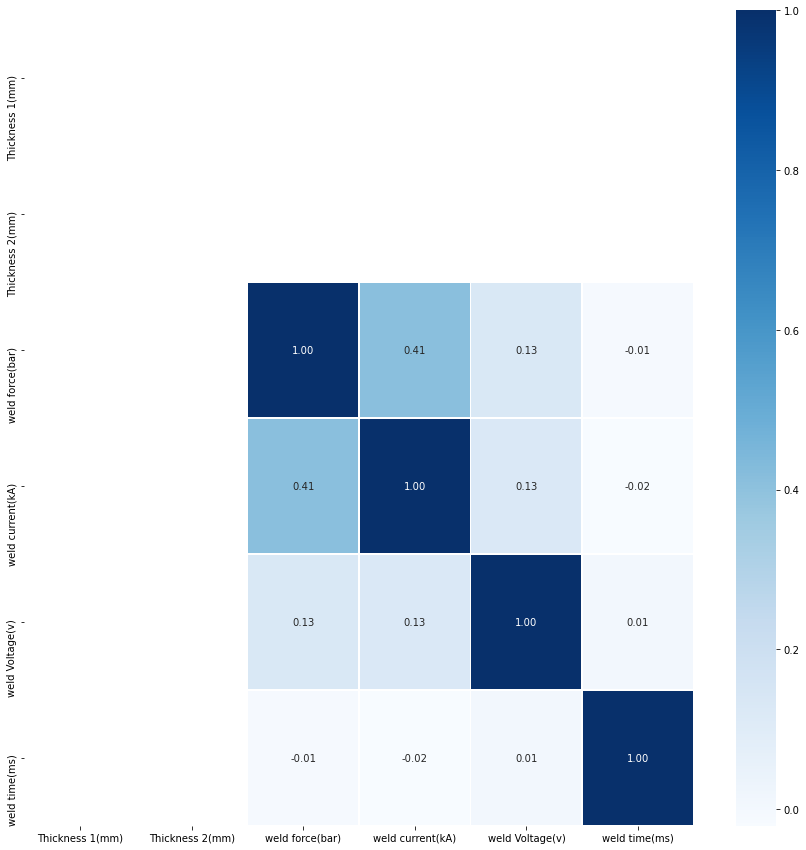

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(data = welding_data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

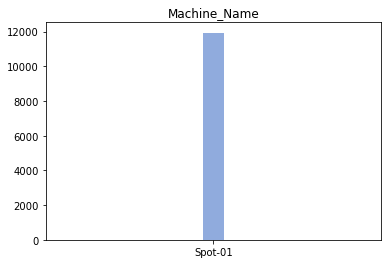

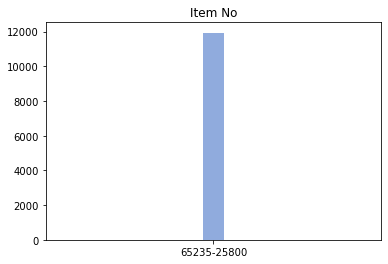

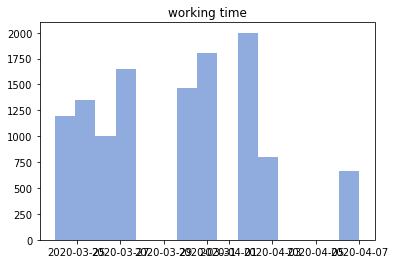

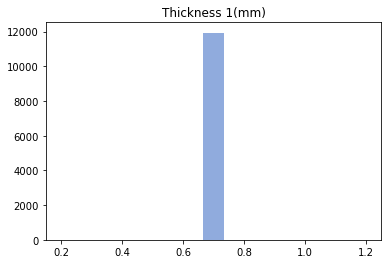

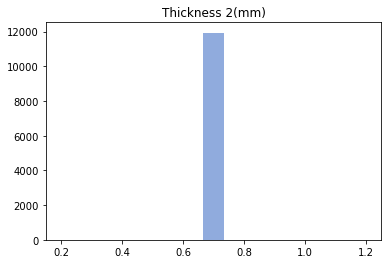

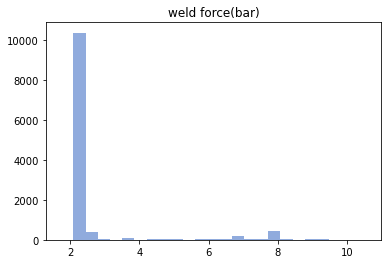

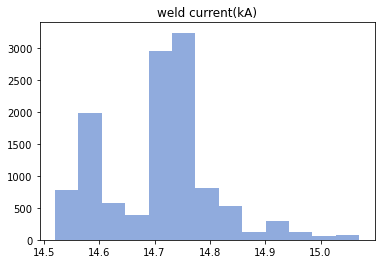

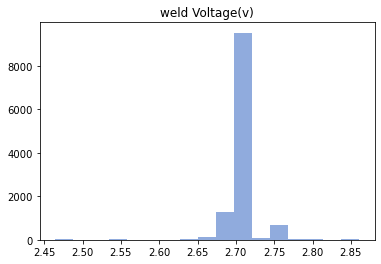

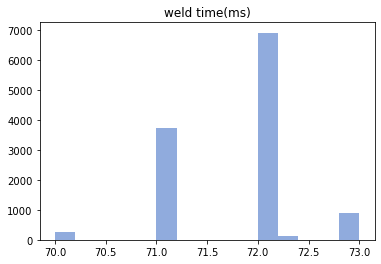

In [8]:
# histogram
bins_list = [15,15,15,15,15,25,13,17,15]
for index, value in enumerate(welding_data.columns):
    plt.figure(index)
    plt.hist(welding_data[value], bins = bins_list[index], facecolor = (144/255, 171/255, 221/255))
    plt.title(value)

## 전처리

In [9]:
# 학습에 사용하지 않을 column (Machine Name,생산품목, 작업시간, 소재두께1, 소재두께2) 제외
new_welding_data = welding_data.iloc[:, 5:]
new_welding_data.head()

,weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
idx,,,,
1,2.33,14.57,2.701,72.0
2,2.36,14.57,2.701,72.0
3,2.37,14.54,2.703,71.0
4,2.37,14.54,2.703,72.0
5,2.36,14.56,2.704,72.0


In [10]:
# 용접 가압력, 전류, 전압, 통전 시간의 단위가 다르므로 scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(new_welding_data)
scaled_data = scaler.transform(new_welding_data)

In [11]:
scaled_data[:5]

array([[0.06704545, 0.09090909, 0.59697733, 0.66666667],
       [0.07045455, 0.09090909, 0.59697733, 0.66666667],
       [0.07159091, 0.03636364, 0.60201511, 0.33333333],
       [0.07159091, 0.03636364, 0.60201511, 0.66666667],
       [0.07045455, 0.07272727, 0.60453401, 0.66666667]])

## 모델 학습

In [12]:
train_data = scaled_data[:8470]
X_test = scaled_data[8470:,:]

In [13]:
X_test.shape

(3469, 4)

In [14]:
X_train, X_valid = train_test_split(train_data, test_size=0.2, random_state=2021)

In [15]:
X_train.shape

(6776, 4)

In [16]:
X_valid.shape

(1694, 4)

In [17]:
X_train[0]

array([0.07159091, 0.16363636, 0.61209068, 0.        ])

In [18]:
# 하이퍼 파라미터 정의
EPOCH = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.01
input_size = len(X_train[0]) # columns 개수 (용접 가압력, 전류, 전압, 통전시간)
hidden_size = 3
output_size =2

In [19]:
# 모델 구현
# encoder model
input_layer1 = layers.Input(shape=(input_size,))
x1 = layers.Dense(hidden_size, activation='relu')(input_layer1)
x1 = layers.Dense(hidden_size*2, activation='relu')(input_layer1)
x1 = layers.Dense(hidden_size, activation='relu')(input_layer1)
output_layer1 = layers.Dense(output_size, activation='relu')(x1)
encoder = Model(input_layer1, output_layer1)
# decoder model
input_layer2 = layers.Input(shape=(output_size,))
x2 = layers.Dense(hidden_size, activation='relu')(input_layer2)
x2 = layers.Dense(hidden_size*2, activation='relu')(input_layer2)
x2 = layers.Dense(hidden_size, activation='relu')(input_layer2)
output_layer2 = layers.Dense(input_size, activation='relu')(x2)
decoder = Model(input_layer2, output_layer2)
# AutoEncoder model
input_auto = layers.Input(shape=(input_size,))
output_auto = decoder(encoder(input_auto))
auto_encoder = Model(input_auto, output_auto)

In [20]:
auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
model (Functional)           (None, 2)                 23        
_________________________________________________________________
model_1 (Functional)         (None, 4)                 25        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [21]:
# 모델 설정
auto_encoder.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                     metrics=['mean_squared_error'])
Checkpoint = ModelCheckpoint(filepath="best_model.h5", verbose=1, save_best_only=True)
hist = auto_encoder.fit(X_train, X_train, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True,
                        validation_data=(X_valid, X_valid), callbacks=[Checkpoint], verbose=1)

Epoch 1/50
106/106 [==============================] - 1s 5ms/step - loss: 0.1537 - mean_squared_error: 0.1537 - val_loss: 0.1452 - val_mean_squared_error: 0.1452

Epoch 00001: val_loss improved from inf to 0.14524, saving model to best_model.h5
Epoch 2/50
106/106 [==============================] - 0s 878us/step - loss: 0.1418 - mean_squared_error: 0.1418 - val_loss: 0.1425 - val_mean_squared_error: 0.1425

Epoch 00002: val_loss improved from 0.14524 to 0.14251, saving model to best_model.h5
Epoch 3/50
106/106 [==============================] - 0s 943us/step - loss: 0.1392 - mean_squared_error: 0.1392 - val_loss: 0.1421 - val_mean_squared_error: 0.1421

Epoch 00003: val_loss improved from 0.14251 to 0.14208, saving model to best_model.h5
Epoch 4/50
106/106 [==============================] - 0s 880us/step - loss: 0.1400 - mean_squared_error: 0.1400 - val_loss: 0.1408 - val_mean_squared_error: 0.1408

Epoch 00004: val_loss improved from 0.14208 to 0.14080, saving model to best_model.h5
Ep

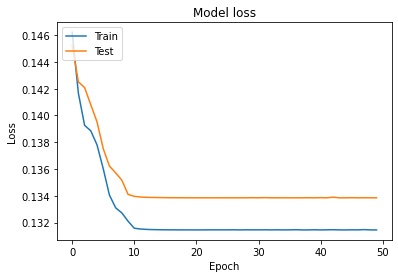

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 모델 예측 결과

In [23]:
# 손실값을 이용한 임계값 정의
test_loss_list = []
for test_data in X_test:
    output = auto_encoder.predict(test_data.reshape(1,-1))
    loss = auto_encoder.evaluate(output,test_data.reshape(1,-1), verbose=0)
    test_loss_list.append(loss)

upper_threshold = np.mean(test_loss_list) + np.std(test_loss_list)*3
lower_threshold = np.mean(test_loss_list) - np.std(test_loss_list)*3

In [24]:
len(test_loss_list)

3469

In [25]:
upper_threshold

0.2524456772925527

In [26]:
lower_threshold

0.0037598626828087983

In [29]:
test_loss_list

[[0.12984901666641235, 0.12984901666641235],
 [0.1308826059103012, 0.1308826059103012],
 [0.1308826059103012, 0.1308826059103012],
 [0.1285746842622757, 0.1285746842622757],
 [0.1285746842622757, 0.1285746842622757],
 [0.13281457126140594, 0.13281457126140594],
 [0.13281457126140594, 0.13281457126140594],
 [0.13520149886608124, 0.13520149886608124],
 [0.13520149886608124, 0.13520149886608124],
 [0.11991211026906967, 0.11991211026906967],
 [0.11991211026906967, 0.11991211026906967],
 [0.12479157000780106, 0.12479157000780106],
 [0.12479157000780106, 0.12479157000780106],
 [0.14723318815231323, 0.14723318815231323],
 [0.14723318815231323, 0.14723318815231323],
 [0.1290486752986908, 0.1290486752986908],
 [0.1290486454963684, 0.1290486454963684],
 [0.13584740459918976, 0.13584740459918976],
 [0.13584740459918976, 0.13584740459918976],
 [0.13973169028759003, 0.13973169028759003],
 [0.13973172008991241, 0.13973172008991241],
 [0.12554185092449188, 0.12554185092449188],
 [0.12554185092449188,

In [27]:
outlier_list = []
for loss in test_loss_list:
    if loss[0] >= upper_threshold or loss[0] <= lower_threshold :
        print(loss)
        outlier_list.append(1)
    else:
        outlier_list.append(0)

[0.2557006776332855, 0.2557006776332855]
[0.2557006776332855, 0.2557006776332855]
[0.27622583508491516, 0.27622583508491516]
[0.27622583508491516, 0.27622583508491516]
[0.33759820461273193, 0.33759820461273193]
[0.33759820461273193, 0.33759820461273193]
[0.26024991273880005, 0.26024991273880005]
[0.26024991273880005, 0.26024991273880005]
[0.27090731263160706, 0.27090731263160706]
[0.27090731263160706, 0.27090731263160706]
[0.3390955626964569, 0.3390955626964569]
[0.3390955626964569, 0.3390955626964569]
[0.2617916762828827, 0.2617916762828827]
[0.25948378443717957, 0.25948378443717957]
[0.26941627264022827, 0.26941627264022827]
[0.2686755061149597, 0.2686755061149597]
[0.33611351251602173, 0.33611351251602173]
[0.34060564637184143, 0.34060564637184143]
[0.3084738850593567, 0.3084738850593567]
[0.30666080117225647, 0.30666080117225647]
[0.2561194896697998, 0.2561194896697998]
[0.2552782893180847, 0.2552782893180847]
[0.30727288126945496, 0.30727288126945496]
[0.30167675018310547, 0.30167

In [28]:
sum = 0
for TF in outlier_list:
    sum += TF
print(sum)

89
